In [9]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Set Random Seeds from Reproducibility

In [11]:
torch.manual_seed(42)

# Check For GPU

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print (f"Using device : {device}")

Using device : cpu


In [14]:
df = pd.read_csv("fmnist_small.csv")

In [15]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


In [16]:
df.shape

(6000, 785)

# Create a 4x4 grid of Image

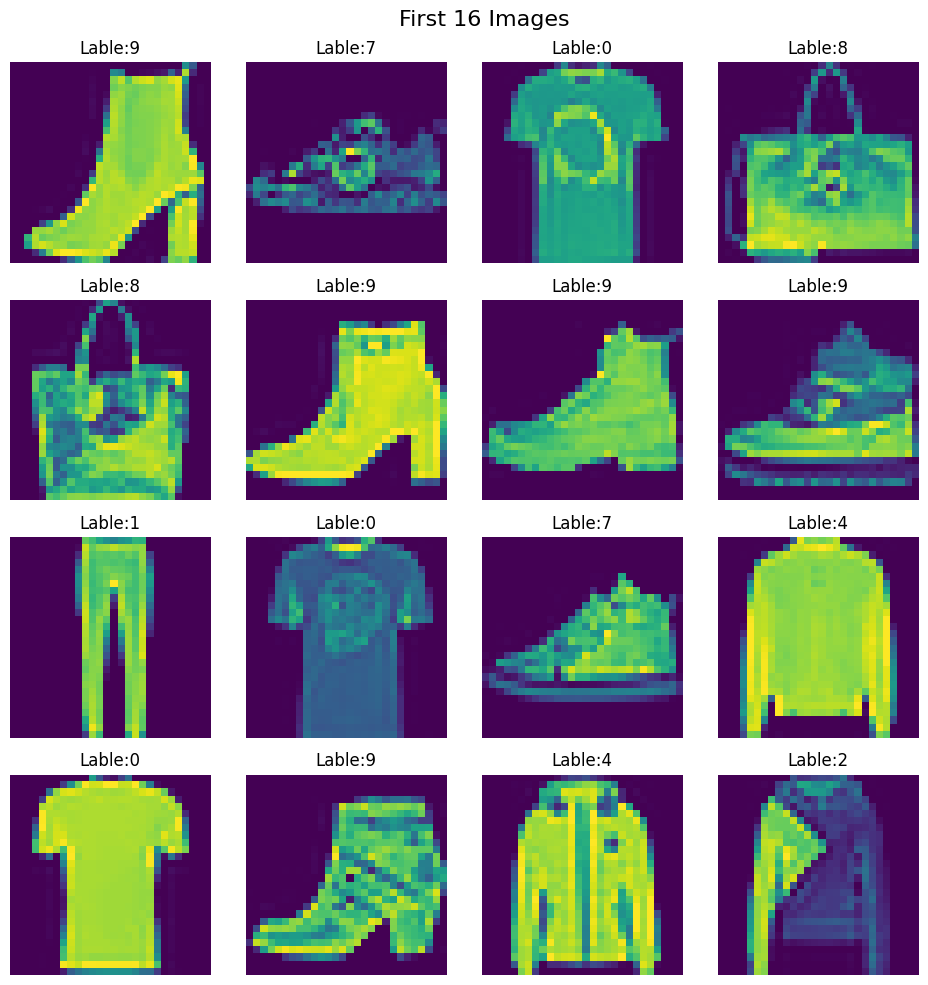

In [33]:
fig, axes = plt.subplots(4,4, figsize=(10,10))
fig.suptitle("First 16 Images", fontsize = 16)



for i, ax in enumerate(axes.flat):
    img = df.iloc[i,1:].values.reshape(28,28)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Lable:{df.iloc[i,0]}")
    
    
plt.tight_layout(rect=[0, 0, 0.96, 1])  
plt.show()

# Train test split

In [34]:
x = df.iloc[:,1:].values
y = df.iloc[:, 0].values

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)

# Transformations

In [39]:
!pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 1.6/1.6 MB 5.0 MB/s eta 0:00:00


In [43]:
from torchvision.transforms import transforms


custom_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
                      
])

In [151]:
from PIL import Image
import numpy as np


class CustomDataset(Dataset):
    
    def __init__(self, features, labels, transform):
        self.features = features
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        
        image = self.features[index].reshape(28,28)                          #resize to (28,28)
        
        image = image.astype(np.uint8)                                       #change datatype to np.uint8
        
        image = np.stack([image] * 3, axis=-1)                               #change black & white to color
        
        image = Image.fromarray(image)                                        #convert array to PIL image
        
        image = self.transform(image)                                        #apply transforms
        
        return image, torch.tensor(self.labels[index], dtype = torch.long)    #retuen
        
    

In [152]:
train_dataset = CustomDataset (x_train, y_train, transform = custom_transform)

In [153]:
test_dataset = CustomDataset (x_test, y_test, transform = custom_transform)

In [154]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = True, pin_memory = True)


# Fetch the Pretrained Model

In [155]:
import torchvision.models as models

vgg16 = models.vgg16(pretrained = True)

In [156]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [157]:
vgg16.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [158]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [159]:
for param in vgg16.features.parameters():
    param.requires_grad = False

In [160]:
vgg16.classifier = nn.Sequential(
    nn.Linear(25088,1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024,512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512,10)

)


In [161]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=512, out_features=10, bias=True)
)

In [162]:
vgg16 = vgg16.to(device)

In [163]:
learning_rate = 0.0001
epochs = 10

In [164]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=learning_rate)

# Training Loop

In [175]:
for epoch in range(epochs):
    
    total_epoch_loss = 0
    
    for batch_features, batch_labels in train_loader:
        
        # move data to gpu
        batch_features, batch_lables = batch_features.to(device), batch_labels.to(device)
        
        # forward pass
        outputs = vgg16(batch_features) 
        
        
        # calculate loss
        loss = criterion(outputs, batch_labels)
        
        # back pass
        optimizer.zero_grad()
        loss.backward()
        
        # update grads
        optimizer.step()
        
        total_epoch_loss = total_epoch_loss + loss.item()
       
    
    avg_loss = total_epoch_loss/len(train_loader)
    print(f'Epoch:{epoch + 1}, Loss:{avg_loss}')

Epoch:1, Loss:0.2319444400568803
Epoch:2, Loss:0.10575396993507942
Epoch:3, Loss:0.04311735009774566
Epoch:4, Loss:0.018052424859876435
Epoch:5, Loss:0.0064667282944234706
Epoch:6, Loss:0.0035028322491173942
Epoch:7, Loss:0.0023905293887946755
Epoch:8, Loss:0.0017612769225767502
Epoch:9, Loss:0.0013202034235776712
Epoch:10, Loss:0.0010073333534334477


In [178]:
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Evaluation on Test Data 

In [185]:
total = 0
correct = 0

with torch.no_grad():
    
    for batch_features, batch_labels in test_loader:
        
        # move data to gpu
        
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        
        outputs = vgg16(batch_features)
        
        _, predicted = torch.max(outputs,1)
        
        total = total+ batch_labels.shape[0]
        
        correct = correct + (predicted == batch_labels).sum().item()
        

print (correct/total)

0.91


# Evaluation on Training Data 

In [186]:
total = 0
correct = 0

with torch.no_grad():
    
    for batch_features, batch_labels in train_loader:
        
        # move data to gpu
        
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        
        outputs = vgg16(batch_features)
        
        _, predicted = torch.max(outputs,1)
        
        total = total+ batch_labels.shape[0]
        
        correct = correct + (predicted == batch_labels).sum().item()
        

print (correct/total)

1.0
